In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('./../data/train.csv', dtype={
                    'cust_id': 'category',
                    'gender': 'category',
                    'age': 'int8',
                    'driving_license': 'int8',
                    'region_code': 'category',
                    'previously_insured': 'int8',
                    'vehicle_age': 'category',
                    'vehicle_damage': 'category',
                    'annual_premium': 'float16',
                    'policy_sales_channel': 'category',
                    'days_since_insured': 'int8',
                    'response': 'int8',
                 })

In [3]:
data.head()

,cust_id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,days_since_insured,response
0,167647,Male,22,1,7.0,1,< 1 Year,No,52.59375,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,866.50000,26.0,-121,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,717.00000,124.0,-3,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,553.00000,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,580.50000,152.0,-45,0


In [4]:
data['response'].unique()

array([0, 1], dtype=int8)

In [5]:
def change_vehicle_age_values(x):
    if x == "< 1 Year":
        return "lt_1_year"
    elif x == "1-2 Year":
        return "bt_1_2_year"
    else:
        return "gt_2_year"

In [6]:
data['vehicle_age'] = data['vehicle_age'].apply(change_vehicle_age_values)

In [7]:
data['vehicle_age'].unique()

['lt_1_year', 'bt_1_2_year', 'gt_2_year']
Categories (3, object): ['bt_1_2_year', 'lt_1_year', 'gt_2_year']

In [8]:
train_data = data

In [9]:
train_data.columns

Index(['cust_id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'days_since_insured', 'response'],
      dtype='object')

In [10]:
# XG BOOST experiments

In [11]:
import sklearn

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

In [13]:
sklearn.__version__

'1.1.1'

In [14]:
num_features = train_data[['age', 'annual_premium', 'days_since_insured']]

In [15]:
cat_features = train_data[['gender', 'driving_license', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'response']]

In [16]:
cardinality_features = train_data[['region_code', 'policy_sales_channel']]

In [17]:
num_pipeline = Pipeline([
    ('imputer1', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler1', RobustScaler())
])

In [18]:
num_transformed = num_pipeline.fit_transform(num_features)

In [19]:
num_transformed

array([[-0.5835 , -1.951  ,  0.02702],
       [ 0.25   ,  0.7803 , -1.207  ],
       [ 1.25   ,  0.2786 , -0.1442 ],
       ...,
       [ 0.375  ,  0.5874 , -0.739  ],
       [-0.3333 , -0.4246 , -0.5493 ],
       [-0.2917 , -0.0872 ,  0.82   ]], dtype=float16)

In [20]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value='most_frequent')),
    ("encoder", OneHotEncoder()),
])

In [21]:
cat_transformed = cat_pipeline.fit_transform(cat_features)

In [22]:
cat_transformed

<382154x13 sparse matrix of type '<class 'numpy.float64'>'
	with 2292924 stored elements in Compressed Sparse Row format>

In [23]:
# from category_encoders.leave_one_out import LeaveOneOutEncoder

In [24]:
cardinality_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value='most_frequent')),
    ("encoder", OrdinalEncoder())
])

In [25]:
cardinality_transformed = cardinality_pipeline.fit_transform(cardinality_features)

In [26]:
cardinality_transformed

array([[50., 58.],
       [21., 79.],
       [27., 28.],
       ...,
       [21., 79.],
       [21., 58.],
       [10., 58.]])

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

In [28]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # return X[self.features].values
        return X[[self.features]]

class DummySelector(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X
    
    def get_feature_names_out(self, *args, **kwargs):
        return args[0]

In [29]:
pipeline = ColumnTransformer([
    ('id', DummySelector(), ['cust_id']),
    ('target', DummySelector(), ['response']),
], sparse_threshold=0, verbose_feature_names_out=True)

In [30]:
pipeline.fit_transform(train_data)

array([['167647', 0],
       ['17163', 0],
       ['32023', 0],
       ...,
       ['165293', 0],
       ['383241', 0],
       ['401019', 0]], dtype=object)

In [31]:
pipeline.get_feature_names_out()

array(['id__cust_id', 'target__response'], dtype=object)

In [32]:
num_features = ['age', 'annual_premium', 'days_since_insured']
num_pipeline = Pipeline([
    ('imputer1', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler1', RobustScaler())
])

In [33]:
cat_features = ['gender', 'driving_license', 'previously_insured', 'vehicle_age', 'vehicle_damage']
cat_pipeline = Pipeline([
    # ('cat_features', DataFrameSelector(cat_features)),
    ("imputer", SimpleImputer(missing_values='NONE', strategy="constant", fill_value='OTHER')),
    ("encoder", OneHotEncoder()),
])

In [34]:
cardinality_features = ['region_code', 'policy_sales_channel']
cardinality_pipeline = Pipeline([
    # ('cardinality_features', DataFrameSelector(cardinality_features)),
    ("imputer", SimpleImputer(missing_values='NONE', strategy="constant", fill_value='OTHER')),
    ("encoder", OrdinalEncoder()),
])

In [35]:
target_feature = ['response']
target_pipeline = Pipeline([
    ("encoder", OneHotEncoder()),
])

In [36]:
target_transformed = target_pipeline.fit_transform(train_data[['response']])

In [37]:
target_transformed

<382154x2 sparse matrix of type '<class 'numpy.float64'>'
	with 382154 stored elements in Compressed Sparse Row format>

In [38]:
pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline), 
    ('cat_pipeline', cat_pipeline),
    ('cardinality_pipeline', cardinality_pipeline)
])

In [41]:
pipeline = ColumnTransformer([
    ('id', DummySelector(), ['cust_id']),
    ('num', num_pipeline, num_features), 
    ('cat', cat_pipeline, cat_features),
    ('car', cardinality_pipeline, cardinality_features)
], sparse_threshold=0, verbose_feature_names_out=True)

In [42]:
pipeline

ColumnTransformer(sparse_threshold=0,
                  transformers=[('id', DummySelector(), ['cust_id']),
                                ('num',
                                 Pipeline(steps=[('imputer1',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler1', RobustScaler())]),
                                 ['age', 'annual_premium',
                                  'days_since_insured']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='OTHER',
                                                                missing_values='NONE',
                                                                strategy='constant')),
                                                 ('encoder', OneHotEncoder())]),
                                 ['gender', 'driving_license',
                                  'previously_insured', 'vehicle_age',
                                  'vehicle_damage']),
                                ('car',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='OTHER',
                                                                missing_values='NONE',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 ['region_code', 'policy_sales_channel'])])

In [572]:
train_transformed = pipeline.fit_transform(train_data)

In [573]:
train_data.head()

,cust_id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,days_since_insured,response
0,167647,Male,22,1,7.0,1,lt_1_year,No,52.59375,152.0,16,0
1,17163,Male,42,1,28.0,0,bt_1_2_year,Yes,866.50000,26.0,-121,0
2,32023,Female,66,1,33.0,0,bt_1_2_year,Yes,717.00000,124.0,-3,0
3,87447,Female,22,1,33.0,0,lt_1_year,No,553.00000,152.0,69,0
4,501933,Male,28,1,46.0,1,lt_1_year,No,580.50000,152.0,-45,0


In [574]:
train_data.dtypes

cust_id                 category
gender                  category
age                         int8
driving_license             int8
region_code             category
previously_insured          int8
vehicle_age             category
vehicle_damage          category
annual_premium           float16
policy_sales_channel    category
days_since_insured          int8
response                    int8
dtype: object

In [575]:
pipeline.get_feature_names_out() 

array(['id__cust_id', 'num__age', 'num__annual_premium',
       'num__days_since_insured', 'cat__gender_Female',
       'cat__gender_Male', 'cat__driving_license_0',
       'cat__driving_license_1', 'cat__previously_insured_0',
       'cat__previously_insured_1', 'cat__vehicle_age_bt_1_2_year',
       'cat__vehicle_age_gt_2_year', 'cat__vehicle_age_lt_1_year',
       'cat__vehicle_damage_No', 'cat__vehicle_damage_Yes',
       'car__region_code', 'car__policy_sales_channel',
       'target__response'], dtype=object)

In [576]:
train_transformed

array([['167647', -0.58349609375, -1.951171875, ..., 50.0, 58.0, 0],
       ['17163', 0.25, 0.7802734375, ..., 21.0, 79.0, 0],
       ['32023', 1.25, 0.278564453125, ..., 27.0, 28.0, 0],
       ...,
       ['165293', 0.375, 0.58740234375, ..., 21.0, 79.0, 0],
       ['383241', -0.333251953125, -0.424560546875, ..., 21.0, 58.0, 0],
       ['401019', -0.291748046875, -0.08721923828125, ..., 10.0, 58.0, 0]],
      dtype=object)

In [577]:
df = pd.DataFrame(train_transformed, columns = pipeline.get_feature_names_out())

In [578]:
removed_cols = set(['id__cust_id', 'target__response'])
all_cols = df.columns 
train_cols = list(set(all_cols) - removed_cols)
train_cols

['car__policy_sales_channel',
 'cat__driving_license_1',
 'cat__vehicle_age_gt_2_year',
 'num__days_since_insured',
 'cat__vehicle_damage_No',
 'num__age',
 'cat__vehicle_age_lt_1_year',
 'cat__previously_insured_0',
 'cat__vehicle_damage_Yes',
 'cat__previously_insured_1',
 'cat__driving_license_0',
 'cat__vehicle_age_bt_1_2_year',
 'num__annual_premium',
 'cat__gender_Female',
 'cat__gender_Male',
 'car__region_code']

In [579]:
df.dtypes

id__cust_id                     object
num__age                        object
num__annual_premium             object
num__days_since_insured         object
cat__gender_Female              object
cat__gender_Male                object
cat__driving_license_0          object
cat__driving_license_1          object
cat__previously_insured_0       object
cat__previously_insured_1       object
cat__vehicle_age_bt_1_2_year    object
cat__vehicle_age_gt_2_year      object
cat__vehicle_age_lt_1_year      object
cat__vehicle_damage_No          object
cat__vehicle_damage_Yes         object
car__region_code                object
car__policy_sales_channel       object
target__response                object
dtype: object

In [580]:
def _calculate_pos_weight_ratio(y_labels):
    ratio = sum(y_labels == 0) // sum(y_labels == 1)
    return ratio

In [581]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df[train_cols].astype('float'), df['target__response'].astype('float'), random_state=31)

In [582]:
X_train.columns

Index(['car__policy_sales_channel', 'cat__driving_license_1',
       'cat__vehicle_age_gt_2_year', 'num__days_since_insured',
       'cat__vehicle_damage_No', 'num__age', 'cat__vehicle_age_lt_1_year',
       'cat__previously_insured_0', 'cat__vehicle_damage_Yes',
       'cat__previously_insured_1', 'cat__driving_license_0',
       'cat__vehicle_age_bt_1_2_year', 'num__annual_premium',
       'cat__gender_Female', 'cat__gender_Male', 'car__region_code'],
      dtype='object')

In [583]:
ratio = _calculate_pos_weight_ratio(y_train)
ratio

5

In [584]:
clf = xgb.XGBClassifier(scale_pos_weight=ratio, objective='binary:logistic', early_stopping_rounds=5, eval_metric=["error", "logloss"], n_estimators=1000)
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-error:0.22796	validation_0-logloss:0.56668	validation_1-error:0.22847	validation_1-logloss:0.56672
[1]	validation_0-error:0.22644	validation_0-logloss:0.50433	validation_1-error:0.22688	validation_1-logloss:0.50444
[2]	validation_0-error:0.22605	validation_0-logloss:0.46817	validation_1-error:0.22659	validation_1-logloss:0.46821
[3]	validation_0-error:0.22794	validation_0-logloss:0.44702	validation_1-error:0.22850	validation_1-logloss:0.44699
[4]	validation_0-error:0.22786	validation_0-logloss:0.43397	validation_1-error:0.22820	validation_1-logloss:0.43402
[5]	validation_0-error:0.22733	validation_0-logloss:0.42526	validation_1-error:0.22749	validation_1-logloss:0.42547
[6]	validation_0-error:0.22961	validation_0-logloss:0.41795	validation_1-error:0.22969	validation_1-logloss:0.41836
[7]	validation_0-error:0.22658	validation_0-logloss:0.41383	validation_1-error:0.22723	validation_1-logloss:0.41444
[8]	validation_0-error:0.22517	validation_0-logloss:0.40907	validation_1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=['error', 'logloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

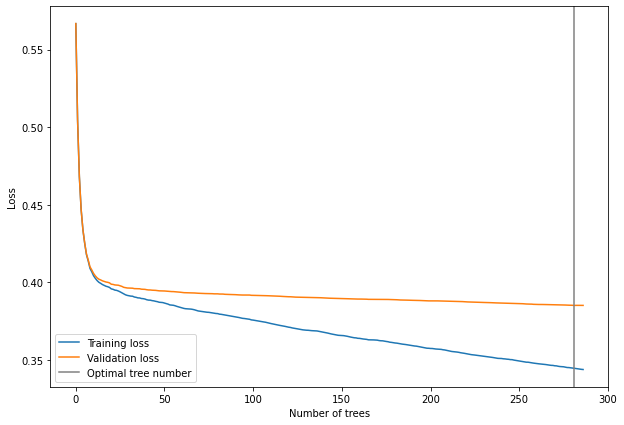

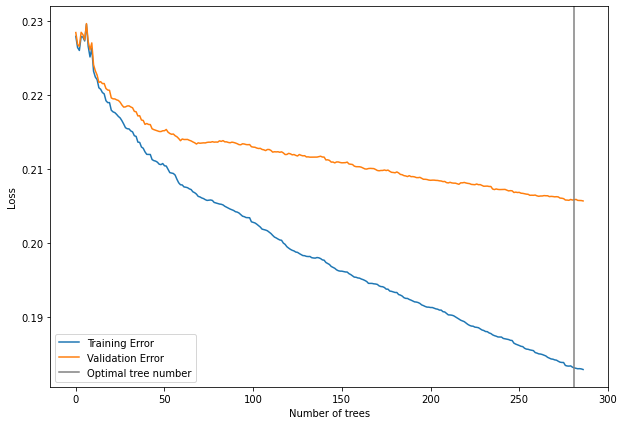

In [585]:
results = clf.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(clf.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["error"], label="Training Error")
plt.plot(results["validation_1"]["error"], label="Validation Error")
plt.axvline(clf.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

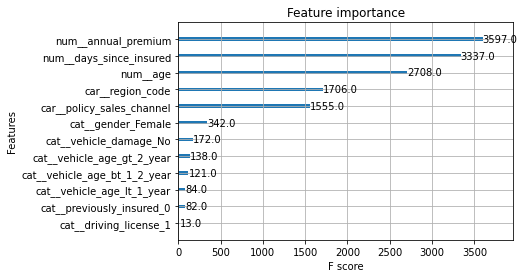

In [586]:
xgb.plot_importance(clf)

In [587]:
# preds = clf.predict(X_val)

In [588]:
probs = clf.predict_proba(X_val, ntree_limit=clf.best_iteration)

C:\Users\gsund\Anaconda3\envs\churn\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [589]:
clf.best_ntree_limit

282

In [590]:
clf.best_iteration 

281

In [591]:
import sklearn.metrics as metrics

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

In [592]:
threshold.shape

(18652,)

In [593]:
print(fpr, tpr, threshold)

[0.         0.         0.         ... 0.99063373 0.99065877 1.        ] [0.00000000e+00 6.37836459e-05 1.27567292e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00] [1.9898690e+00 9.8986900e-01 9.8312920e-01 ... 2.4486901e-05 2.4469464e-05
 6.6752494e-07]


In [594]:
from matplotlib import pyplot
from numpy import sqrt
from numpy import argmax

Best Threshold=0.474209, G-Mean=0.829


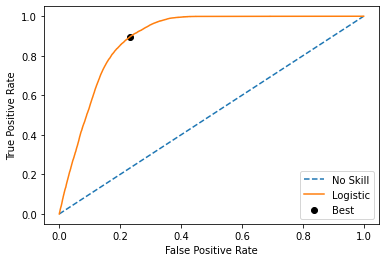

In [595]:
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.642372, F-Score=0.600


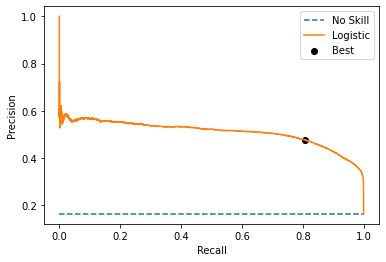

In [596]:
precision, recall, thresholds = metrics.precision_recall_curve(y_val, preds)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [523]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [524]:
from numpy import arange

thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [metrics.f1_score(y_val, to_labels(preds, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.698, F-Score=0.60656


In [550]:
y_preds_pr = to_labels(preds, 0.69)

In [551]:
print(metrics.classification_report(y_val, y_preds_pr))

print(metrics.confusion_matrix(y_val, y_preds_pr))

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85     19724
         1.0       0.56      0.31      0.40      7076

    accuracy                           0.75     26800
   macro avg       0.67      0.61      0.62     26800
weighted avg       0.73      0.75      0.73     26800

[[18004  1720]
 [ 4882  2194]]


In [528]:


# Optimized the Precision(less number of +ve pred) and Recall - max f1 score

[[66870 12991]
 [ 3209 12469]]


In [529]:
y_preds_roc = to_labels(preds, 0.50)

In [530]:
print(metrics.classification_report(y_val, y_preds_roc))

              precision    recall  f1-score   support

         0.0       0.98      0.76      0.86     79861
         1.0       0.43      0.91      0.58     15678

    accuracy                           0.79     95539
   macro avg       0.70      0.84      0.72     95539
weighted avg       0.89      0.79      0.81     95539



In [531]:
print(metrics.confusion_matrix(y_val, y_preds_roc))

# Increasing the recall(TPR)( more false +ve rates ) by decreasing the False Positive Rate 

[[61050 18811]
 [ 1467 14211]]


In [267]:
sum(y_val)

15678.0

In [268]:
1664 + 14014

15678

In [228]:
roc_auc

0.9208572428559414

In [224]:
probs

array([[7.9151654e-01, 2.0848344e-01],
       [9.9965805e-01, 3.4192408e-04],
       [9.9955356e-01, 4.4643428e-04],
       ...,
       [9.9982953e-01, 1.7049715e-04],
       [9.9995577e-01, 4.4234515e-05],
       [9.9903500e-01, 9.6499204e-04]], dtype=float32)

In [219]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [221]:
clf.score(X_val, y_val)

0.83255005809146

In [216]:
X_train.head()

,car__policy_sales_channel,cat__driving_license_1,cat__vehicle_age_gt_2_year,num__days_since_insured,cat__vehicle_damage_No,num__age,cat__vehicle_age_lt_1_year,cat__previously_insured_0,cat__vehicle_damage_Yes,cat__previously_insured_1,cat__driving_license_0,cat__vehicle_age_bt_1_2_year,id__cust_id,num__annual_premium,cat__gender_Female,cat__gender_Male,car__region_code
191638,84.0,1.0,0.0,-0.198242,0.0,0.333252,0.0,1.0,1.0,0.0,0.0,1.0,87786.0,0.770020,1.0,0.0,41.0
203443,28.0,1.0,0.0,0.819824,0.0,0.958496,0.0,0.0,1.0,1.0,0.0,1.0,304880.0,0.055359,0.0,1.0,38.0
98704,79.0,1.0,0.0,0.963867,0.0,0.541504,0.0,1.0,1.0,0.0,0.0,1.0,328897.0,2.308594,0.0,1.0,21.0
48177,67.0,1.0,0.0,-0.927734,1.0,-0.625000,1.0,0.0,0.0,1.0,0.0,0.0,250559.0,-0.214722,0.0,1.0,41.0
114725,28.0,1.0,0.0,-0.423340,1.0,1.000000,0.0,0.0,0.0,1.0,0.0,1.0,247170.0,0.261719,0.0,1.0,21.0


In [210]:
sum(y_train == 0.0) / sum(y_train == 1.0)

5.10819853803039

In [388]:
# Trying region based models, 'region_code'

In [532]:
cardinality_features = ['policy_sales_channel']
pipeline1 = ColumnTransformer([
    ('id', DummySelector(), ['cust_id']),
    ('num', num_pipeline, num_features), 
    ('cat', cat_pipeline, cat_features),
    ('car', cardinality_pipeline, cardinality_features),
    ('target', DummySelector(), ['response'])
], sparse_threshold=0, verbose_feature_names_out=True)

In [533]:
train_data_28 = train_data.loc[train_data['region_code'] == '28.0']
train_data_28 = train_data_28.loc[:, train_data_28.columns!='region_code']

In [534]:
train_transformed_28 = pipeline1.fit_transform(train_data_28)

In [535]:
pipeline1.get_feature_names_out() 

array(['id__cust_id', 'num__age', 'num__annual_premium',
       'num__days_since_insured', 'cat__gender_Female',
       'cat__gender_Male', 'cat__driving_license_0',
       'cat__driving_license_1', 'cat__previously_insured_0',
       'cat__previously_insured_1', 'cat__vehicle_age_bt_1_2_year',
       'cat__vehicle_age_gt_2_year', 'cat__vehicle_age_lt_1_year',
       'cat__vehicle_damage_No', 'cat__vehicle_damage_Yes',
       'car__policy_sales_channel', 'target__response'], dtype=object)

In [536]:
df_28 = pd.DataFrame(train_transformed_28, columns = pipeline1.get_feature_names_out())

In [537]:
removed_cols = set(['id__cust_id', 'target__response'])
all_cols = df_28.columns 
train_cols = list(set(all_cols) - removed_cols)
train_cols

['car__policy_sales_channel',
 'cat__driving_license_1',
 'cat__vehicle_age_gt_2_year',
 'num__days_since_insured',
 'cat__vehicle_damage_No',
 'num__age',
 'cat__vehicle_age_lt_1_year',
 'cat__previously_insured_0',
 'cat__vehicle_damage_Yes',
 'cat__previously_insured_1',
 'cat__driving_license_0',
 'cat__vehicle_age_bt_1_2_year',
 'num__annual_premium',
 'cat__gender_Female',
 'cat__gender_Male']

In [538]:
X_train, X_val, y_train, y_val = train_test_split(df_28[train_cols].astype('float'), df_28['target__response'].astype('float'), random_state=31)

In [539]:
ratio = _calculate_pos_weight_ratio(y_train)
ratio

2

In [557]:
clf = xgb.XGBClassifier(scale_pos_weight=ratio, objective='binary:logistic', early_stopping_rounds=5, n_estimators=1000, eval_metric=["error", "logloss"])
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-error:0.26995	validation_0-logloss:0.59375	validation_1-error:0.26739	validation_1-logloss:0.59356
[1]	validation_0-error:0.28698	validation_0-logloss:0.54106	validation_1-error:0.28280	validation_1-logloss:0.54053
[2]	validation_0-error:0.26558	validation_0-logloss:0.50888	validation_1-error:0.26295	validation_1-logloss:0.50825
[3]	validation_0-error:0.27652	validation_0-logloss:0.48799	validation_1-error:0.27362	validation_1-logloss:0.48755
[4]	validation_0-error:0.26947	validation_0-logloss:0.47379	validation_1-error:0.26612	validation_1-logloss:0.47360
[5]	validation_0-error:0.26313	validation_0-logloss:0.46373	validation_1-error:0.26097	validation_1-logloss:0.46383
[6]	validation_0-error:0.26383	validation_0-logloss:0.45625	validation_1-error:0.26160	validation_1-logloss:0.45675
[7]	validation_0-error:0.26669	validation_0-logloss:0.45115	validation_1-error:0.26362	validation_1-logloss:0.45178
[8]	validation_0-error:0.26549	validation_0-logloss:0.44732	validation_1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=['error', 'logloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

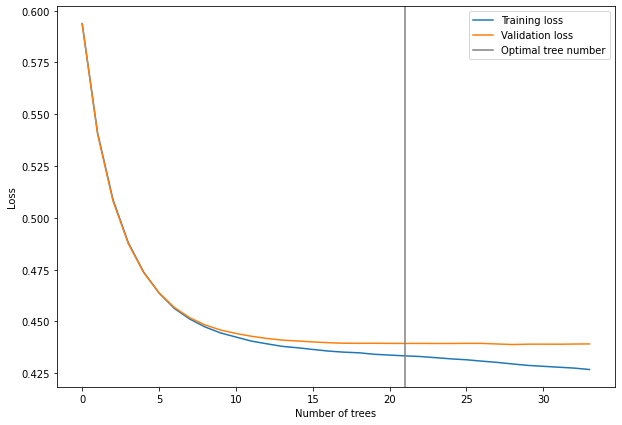

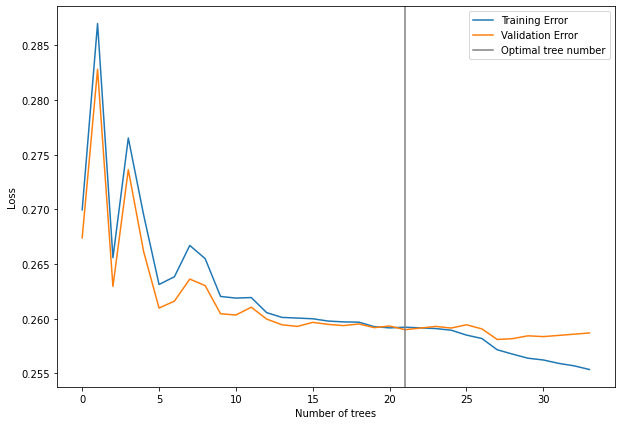

In [558]:
results = clf.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["error"], label="Training Error")
plt.plot(results["validation_1"]["error"], label="Validation Error")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [559]:
probs = clf.predict_proba(X_val)

Best Threshold=0.496771, G-Mean=0.774


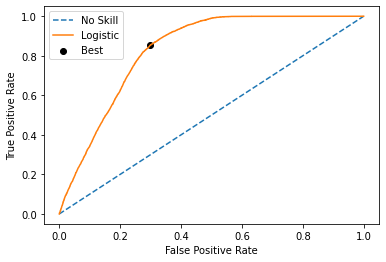

In [560]:
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


Best Threshold=0.496771, F-Score=0.636


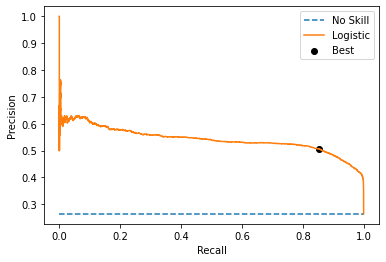

In [561]:
precision, recall, thresholds = metrics.precision_recall_curve(y_val, preds)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [562]:
y_preds_roc = to_labels(preds, 0.496)

In [563]:
print(metrics.classification_report(y_val, y_preds_roc))

print(metrics.confusion_matrix(y_val, y_preds_roc))

              precision    recall  f1-score   support

         0.0       0.93      0.70      0.80     19724
         1.0       0.51      0.85      0.64      7076

    accuracy                           0.74     26800
   macro avg       0.72      0.78      0.72     26800
weighted avg       0.82      0.74      0.76     26800

[[13836  5888]
 [ 1040  6036]]


In [555]:
y_preds_pr = to_labels(preds, 0.87)

In [556]:
print(metrics.classification_report(y_val, y_preds_pr))

print(metrics.confusion_matrix(y_val, y_preds_pr))

              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85     19724
         1.0       0.50      0.00      0.00      7076

    accuracy                           0.74     26800
   macro avg       0.62      0.50      0.42     26800
weighted avg       0.67      0.74      0.62     26800

[[19721     3]
 [ 7073     3]]


In [598]:
train_data_8 = train_data.loc[train_data['region_code'] == '8.0']
train_data_8 = train_data_8.loc[:, train_data_8.columns!='region_code']

In [599]:
train_transformed_8 = pipeline1.fit_transform(train_data_8)
df_8 = pd.DataFrame(train_transformed_8, columns = pipeline1.get_feature_names_out())

removed_cols = set(['id__cust_id', 'target__response'])
all_cols = df_8.columns 
train_cols = list(set(all_cols) - removed_cols)
train_cols

['car__policy_sales_channel',
 'cat__driving_license_1',
 'cat__vehicle_age_gt_2_year',
 'num__days_since_insured',
 'cat__vehicle_damage_No',
 'num__age',
 'cat__vehicle_age_lt_1_year',
 'cat__previously_insured_0',
 'cat__vehicle_damage_Yes',
 'cat__previously_insured_1',
 'cat__driving_license_0',
 'cat__vehicle_age_bt_1_2_year',
 'num__annual_premium',
 'cat__gender_Female',
 'cat__gender_Male']

In [600]:
X_train, X_val, y_train, y_val = train_test_split(df_8[train_cols].astype('float'), df_8['target__response'].astype('float'), random_state=31)

ratio = _calculate_pos_weight_ratio(y_train)
ratio

6

In [605]:
df_8.head()

,id__cust_id,num__age,num__annual_premium,num__days_since_insured,cat__gender_Female,cat__gender_Male,cat__driving_license_0,cat__driving_license_1,cat__previously_insured_0,cat__previously_insured_1,cat__vehicle_age_bt_1_2_year,cat__vehicle_age_gt_2_year,cat__vehicle_age_lt_1_year,cat__vehicle_damage_No,cat__vehicle_damage_Yes,car__policy_sales_channel,target__response
0,71711,0.640137,-2.404297,-0.54541,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,39.0,0
1,31460,-0.399902,1.823242,0.54541,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,22.0,0
2,389010,-0.360107,0.719238,-0.009094,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,22.0,0
3,303609,-0.52002,1.930664,0.009094,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,22.0,0
4,264880,-0.52002,-0.05719,0.081848,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,22.0,0


In [606]:
clf = xgb.XGBClassifier(scale_pos_weight=ratio, objective='binary:logistic', early_stopping_rounds=5, n_estimators=1000, eval_metric=["error", "logloss"])
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-error:0.20302	validation_0-logloss:0.54834	validation_1-error:0.20551	validation_1-logloss:0.54957
[1]	validation_0-error:0.20157	validation_0-logloss:0.47393	validation_1-error:0.20410	validation_1-logloss:0.47695
[2]	validation_0-error:0.19882	validation_0-logloss:0.43160	validation_1-error:0.20115	validation_1-logloss:0.43565
[3]	validation_0-error:0.19737	validation_0-logloss:0.40535	validation_1-error:0.19986	validation_1-logloss:0.41007
[4]	validation_0-error:0.19760	validation_0-logloss:0.38744	validation_1-error:0.20033	validation_1-logloss:0.39393
[5]	validation_0-error:0.19474	validation_0-logloss:0.37625	validation_1-error:0.19856	validation_1-logloss:0.38370
[6]	validation_0-error:0.19489	validation_0-logloss:0.36792	validation_1-error:0.19951	validation_1-logloss:0.37653
[7]	validation_0-error:0.19434	validation_0-logloss:0.36098	validation_1-error:0.19998	validation_1-logloss:0.37027
[8]	validation_0-error:0.19709	validation_0-logloss:0.35623	validation_1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=['error', 'logloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

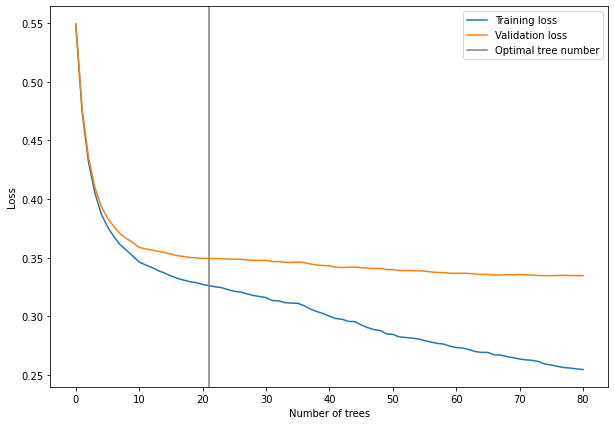

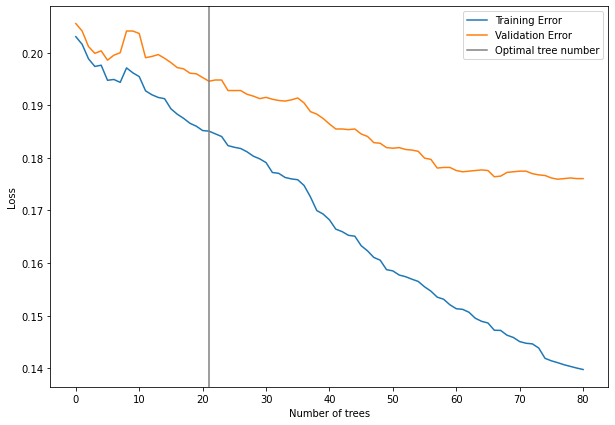

In [608]:
results = clf.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["error"], label="Training Error")
plt.plot(results["validation_1"]["error"], label="Validation Error")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

C:\Users\gsund\Anaconda3\envs\churn\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Best Threshold=0.443348, G-Mean=0.848


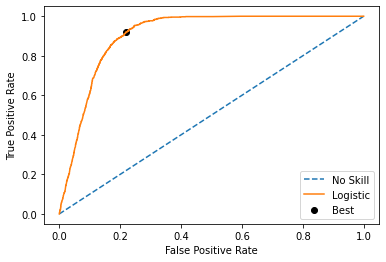

Best Threshold=0.715360, F-Score=0.584


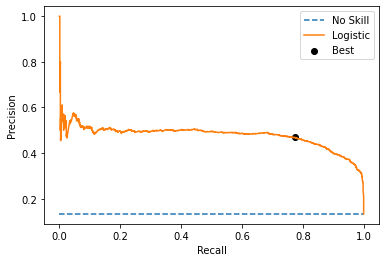

In [618]:
probs = clf.predict_proba(X_val, ntree_limit=25)
# probs = clf.predict_proba(X_val)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


precision, recall, thresholds = metrics.precision_recall_curve(y_val, preds)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [619]:
y_preds_pr = to_labels(preds, 0.96)

In [615]:
metrics.precision_score(y_val, y_preds_pr)

0.3333333333333333

In [620]:
from sklearn.model_selection import GridSearchCV

In [621]:
parameters = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

In [622]:
clf = xgb.XGBClassifier(scale_pos_weight=ratio, objective='binary:logistic', early_stopping_rounds=5, n_estimators=1000, eval_metric=["error", "logloss"])

In [ ]:
# clf = GridSearchCV(clf, param_distributions=params, scoring='f1_score')
# clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

In [628]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 3,
    verbose=3
)

In [629]:
grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
# grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[0]	validation_0-error:0.20322	validation_0-logloss:0.55014	validation_1-error:0.20481	validation_1-logloss:0.55095
[1]	validation_0-error:0.20130	validation_0-logloss:0.47758	validation_1-error:0.20257	validation_1-logloss:0.47937
[2]	validation_0-error:0.20031	validation_0-logloss:0.43594	validation_1-error:0.20245	validation_1-logloss:0.43850
[3]	validation_0-error:0.19941	validation_0-logloss:0.41031	validation_1-error:0.20127	validation_1-logloss:0.41321
[4]	validation_0-error:0.20063	validation_0-logloss:0.39404	validation_1-error:0.20304	validation_1-logloss:0.39731
[5]	validation_0-error:0.20031	validation_0-logloss:0.38246	validation_1-error:0.20328	validation_1-logloss:0.38651
[6]	validation_0-error:0.19973	validation_0-logloss:0.37488	validation_1-error:0.20304	validation_1-logloss:0.37985
[7]	validation_0-error:0.19953	validation_0-logloss:0.36817	validation_1-error:0.20257	validation_1-logloss:0.37364
[8]	vali

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=5,
                                     enable_categorical=False,
                                     eval_metric=['error', 'logloss'],
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=10,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='f1_micro', verbose=3)

In [632]:
model = grid_search.best_estimator_

In [648]:
model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=['error', 'logloss'], gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [634]:
prob = model.predict_proba(X_val)

In [635]:
preds = prob[:, 1]

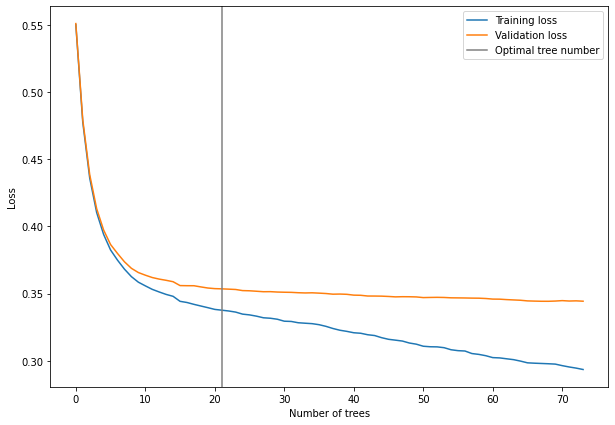

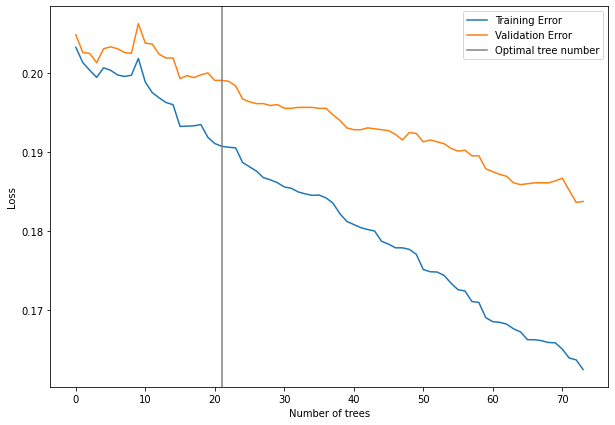

In [636]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["error"], label="Training Error")
plt.plot(results["validation_1"]["error"], label="Validation Error")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

Best Threshold=0.369292, G-Mean=0.848


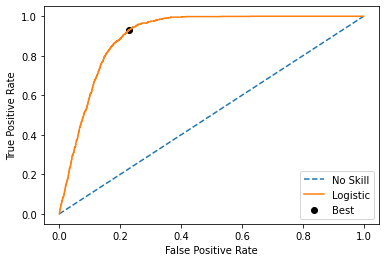

Best Threshold=0.656464, F-Score=0.577


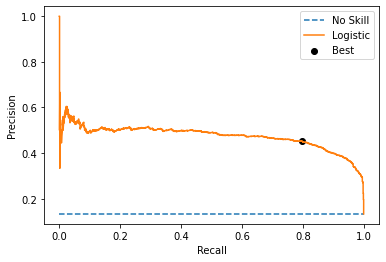

In [637]:
probs = model.predict_proba(X_val, ntree_limit=25)
# probs = clf.predict_proba(X_val)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


precision, recall, thresholds = metrics.precision_recall_curve(y_val, preds)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [649]:
train_data_46 = train_data.loc[train_data['region_code'] == '46.0']
train_data_46 = train_data_46.loc[:, train_data_46.columns!='region_code']

In [650]:
train_transformed_46 = pipeline1.fit_transform(train_data_46)
df_46 = pd.DataFrame(train_transformed_46, columns = pipeline1.get_feature_names_out())

removed_cols = set(['id__cust_id', 'target__response'])
all_cols = df_46.columns 
train_cols = list(set(all_cols) - removed_cols)
train_cols

['car__policy_sales_channel',
 'cat__driving_license_1',
 'cat__vehicle_age_gt_2_year',
 'num__days_since_insured',
 'cat__vehicle_damage_No',
 'num__age',
 'cat__vehicle_age_lt_1_year',
 'cat__previously_insured_0',
 'cat__vehicle_damage_Yes',
 'cat__previously_insured_1',
 'cat__driving_license_0',
 'cat__vehicle_age_bt_1_2_year',
 'num__annual_premium',
 'cat__gender_Female',
 'cat__gender_Male']

In [652]:
X_train, X_val, y_train, y_val = train_test_split(df_46[train_cols].astype('float'), df_46['target__response'].astype('float'), random_state=31)

ratio = _calculate_pos_weight_ratio(y_train)
ratio

6

In [653]:
clf = xgb.XGBClassifier(scale_pos_weight=ratio, objective='binary:logistic', early_stopping_rounds=5, n_estimators=1000, eval_metric=["error", "logloss"])

In [654]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 3,
    verbose=3
)

In [655]:
grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[0]	validation_0-error:0.20954	validation_0-logloss:0.55194	validation_1-error:0.21342	validation_1-logloss:0.55370
[1]	validation_0-error:0.18413	validation_0-logloss:0.48029	validation_1-error:0.18808	validation_1-logloss:0.48286
[2]	validation_0-error:0.21324	validation_0-logloss:0.43972	validation_1-error:0.21758	validation_1-logloss:0.44282
[3]	validation_0-error:0.19766	validation_0-logloss:0.41352	validation_1-error:0.20016	validation_1-logloss:0.41705
[4]	validation_0-error:0.19872	validation_0-logloss:0.39724	validation_1-error:0.20115	validation_1-logloss:0.40096
[5]	validation_0-error:0.21020	validation_0-logloss:0.38710	validation_1-error:0.21184	validation_1-logloss:0.39065
[6]	validation_0-error:0.20017	validation_0-logloss:0.37888	validation_1-error:0.20293	validation_1-logloss:0.38241
[7]	validation_0-error:0.20096	validation_0-logloss:0.37374	validation_1-error:0.20412	validation_1-logloss:0.37789
[8]	vali

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=5,
                                     enable_categorical=False,
                                     eval_metric=['error', 'logloss'],
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=10,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=3)

In [656]:
model = grid_search.best_estimator_

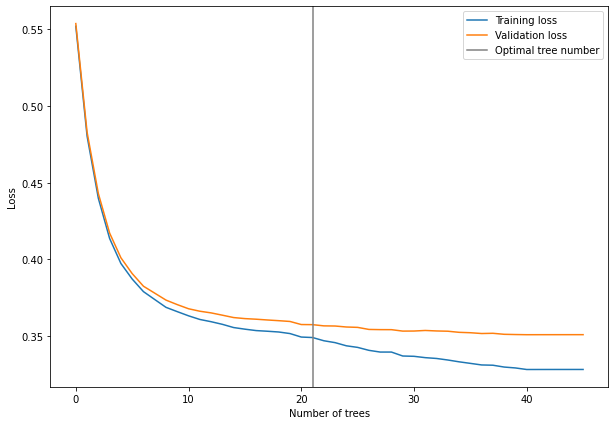

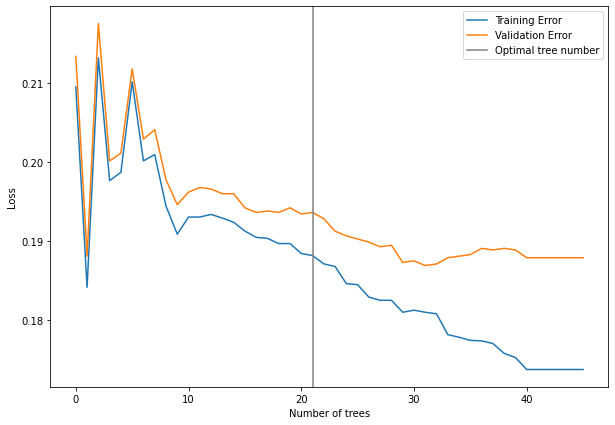

In [657]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["error"], label="Training Error")
plt.plot(results["validation_1"]["error"], label="Validation Error")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

C:\Users\gsund\Anaconda3\envs\churn\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Best Threshold=0.535233, G-Mean=0.854


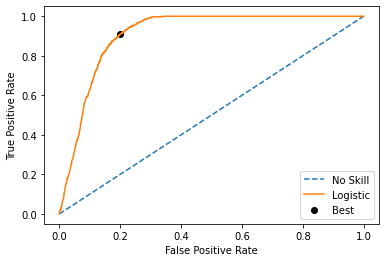

Best Threshold=0.736224, F-Score=0.608


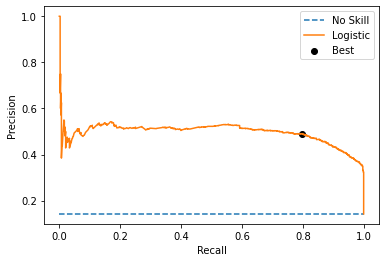

In [658]:
probs = model.predict_proba(X_val, ntree_limit=25)
# probs = clf.predict_proba(X_val)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


precision, recall, thresholds = metrics.precision_recall_curve(y_val, preds)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

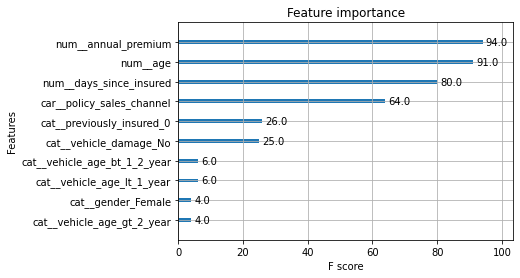

In [661]:
from xgboost import XGBClassifier, plot_importance

ax = plot_importance(model)